# Decontextualized Emotion Recognition
This project's approach centers on "emotion + decontextualization"

## File Notes
Overview:
This dataset contains 144 facial images, organized by the cross-structure of emotion and context.
It uses dual labeling for visual cues and context, with metadata records to reveal the dataset construction logic.
The project explores whether emotion can be computed in a decontextualized way.

This notebook's approaches:
- Use ResNet18 for fine-tuning emotion classification
- Run test evaluation and single-image prediction visualization
- Run a "black-and-white decontextualization" comparison experiment

Purpose: Evaluate how context affects emotion recognition by comparing original and decontextualized inputs.



## Part 0: Setup
### Imports


**import required libraries.**


In [ ]:
import numpy as np  
import matplotlib.pyplot as plt  
import pathlib  
from PIL import Image, ImageOps  
import time
from copy import deepcopy
import random
import json

import torch  
from torch import nn  
import torchvision as tv  
import torchvision.models as models  
from torch.utils.data import DataLoader, Subset  
from torchvision.transforms import v2  


### Device + Seed


**define reproducible random seed settings.**


In [2]:
def set_seed(seed: int = 42):
    # Fix random seeds to reduce run-to-run variance
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    if torch.backends.cudnn.is_available():
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
    try:
        torch.use_deterministic_algorithms(True)
    except Exception:
        # Skip if strict determinism is unsupported by some devices/ops
        pass


# Fix randomness first, then choose the training device
set_seed(42)
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")


Using mps device


### Paths + Config


**run optional multi-seed stability evaluation.**


In [3]:
data_dir = pathlib.Path("dataset")
models_dir = pathlib.Path("models")
models_dir.mkdir(exist_ok=True)

model_name = "image_classifier"
model_dir = models_dir / model_name
model_dir.mkdir(exist_ok=True)

# Data split parameters (stratified)
val_size = 0.2
test_size = 0.1
batch_size = 6
num_workers = 0

# Two-stage fine-tuning hyperparams: train the head first, then full fine-tune
epochs_head = 5
epochs_finetune = 20
learning_rate_head = 3e-4
learning_rate_finetune = 1e-4
weight_decay = 1e-4
scheduler_step = 5
scheduler_gamma = 0.2

# Optional: multi-seed evaluation (disabled by default to save time)
multi_seed_eval = False
seed_list = [42, 52, 62]

# Stability-enhanced evaluation config (Bootstrap + TTA)
eval_bootstrap_rounds = 1000
tta_passes = 5


### Utility Functions


Purpose: split samples into train/val/test by class.
#### split_indices (stratified split)


**define stratified dataset split function.**


In [4]:
def split_indices(labels, val_size: float, test_size: float, seed: int = 42):
    if val_size + test_size >= 1:
        raise ValueError("val_size + test_size must be < 1")

    rng = np.random.default_rng(seed)
    labels_np = np.array(labels)
    classes = np.unique(labels_np)

    train_idx, val_idx, test_idx = [], [], []
    for cls in classes:
        cls_idx = np.where(labels_np == cls)[0]
        rng.shuffle(cls_idx)
        n = len(cls_idx)

        n_val = max(1, int(round(n * val_size)))
        n_test = max(1, int(round(n * test_size)))

        if n_val + n_test >= n:
            n_val = max(1, int(np.floor(n * val_size)))
            n_test = max(1, int(np.floor(n * test_size)))
            while n_val + n_test >= n and n_test > 1:
                n_test -= 1
            while n_val + n_test >= n and n_val > 1:
                n_val -= 1
            if n_val + n_test >= n:
                raise ValueError(f"Class {cls} has too few samples: {n}")

        val_idx.extend(cls_idx[:n_val].tolist())
        test_idx.extend(cls_idx[n_val:n_val+n_test].tolist())
        train_idx.extend(cls_idx[n_val+n_test:].tolist())

    rng.shuffle(train_idx)
    rng.shuffle(val_idx)
    rng.shuffle(test_idx)
    return train_idx, val_idx, test_idx



#### evaluate


**define evaluation metrics on a dataloader.**


In [5]:
# Purpose: compute average loss and accuracy for a given dataloader.
def evaluate(model, dataloader, criterion, device):
    model.eval()
    running_loss, running_correct, total = 0.0, 0, 0
    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            logits = model(x)
            loss = criterion(logits, y)
            pred = logits.argmax(dim=1)
            bs = x.size(0)
            running_loss += loss.item() * bs
            running_correct += (pred == y).sum().item()
            total += bs
    return running_loss / total, running_correct / total



Purpose: train in two phases over `train/val` and save the best validation weights.
#### train_transfer_model (official-style training loop)


**define transfer learning training loop.**


In [6]:
def train_transfer_model(model, dataloaders, dataset_sizes, criterion, optimizer, device, num_epochs, scheduler=None):
    since = time.time()
    best_model_wts = deepcopy(model.state_dict())
    best_acc = 0.0

    train_losses, val_losses, val_accs = [], [], []

    for epoch in range(num_epochs):
        print(f"Epoch {epoch + 1:02d}/{num_epochs}")

        for phase in ["train", "val"]:
            # Enable gradients in train; forward-only in val
            model.train() if phase == "train" else model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == "train"):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == "train":
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += (preds == labels).sum().item()

            if phase == "train" and scheduler is not None:
                scheduler.step()

            epoch_loss = running_loss / max(1, dataset_sizes[phase])
            epoch_acc = running_corrects / max(1, dataset_sizes[phase])

            if phase == "train":
                train_losses.append(epoch_loss)
                print(f"  train_loss={epoch_loss:.4f}")
            else:
                val_losses.append(epoch_loss)
                val_accs.append(epoch_acc)
                print(f"  val_loss={epoch_loss:.4f} | val_acc={epoch_acc:.4f}")

                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = deepcopy(model.state_dict())

        print('-' * 50)

    elapsed = time.time() - since
    model.load_state_dict(best_model_wts)
    print(f"Training complete in {elapsed / 60:.1f}m")
    print(f"Best val_acc: {best_acc:.4f}")
    return model, train_losses, val_losses, val_accs


# Backward-compatible alias (doesn't affect later cells)
def train_model(model, train_loader, val_loader, criterion, optimizer, device, epochs, scheduler=None):
    dataloaders = {"train": train_loader, "val": val_loader}
    dataset_sizes = {"train": len(train_loader.dataset), "val": len(val_loader.dataset)}
    return train_transfer_model(
        model=model,
        dataloaders=dataloaders,
        dataset_sizes=dataset_sizes,
        criterion=criterion,
        optimizer=optimizer,
        device=device,
        num_epochs=epochs,
        scheduler=scheduler,
    )


## Part 1: Data for Fine-tuning


This section defines image transforms and builds stratified train/validation/test splits for transfer learning.


In [7]:
transfer_train_transform = v2.Compose([
    v2.RandomResizedCrop(224),
    v2.RandomHorizontalFlip(),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

transfer_val_transform = v2.Compose([
    v2.Resize(256),
    v2.CenterCrop(224),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Base dataset used only to get classes/targets/samples
transfer_base_dataset = datasets.ImageFolder(data_dir, transform=transfer_val_transform)
class_names = transfer_base_dataset.classes
num_classes = len(class_names)

# Stratified split to keep class distribution more balanced across train/val/test
train_idx, val_idx, test_idx = split_indices(transfer_base_dataset.targets, val_size, test_size, seed=42)

transfer_train_dataset = Subset(datasets.ImageFolder(data_dir, transform=transfer_train_transform), train_idx)
transfer_val_dataset = Subset(datasets.ImageFolder(data_dir, transform=transfer_val_transform), val_idx)
transfer_test_dataset = Subset(datasets.ImageFolder(data_dir, transform=transfer_val_transform), test_idx)

transfer_train_loader = DataLoader(transfer_train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
transfer_val_loader = DataLoader(transfer_val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
transfer_test_loader = DataLoader(transfer_test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

# Backward-compatible variable name to avoid large downstream changes
base_ds = transfer_base_dataset
train_ds, val_ds, test_ds = transfer_train_dataset, transfer_val_dataset, transfer_test_dataset
train_loader, val_loader, test_loader = transfer_train_loader, transfer_val_loader, transfer_test_loader
transfer_eval_transform = transfer_val_transform

print('Classes:', class_names)
print(f'Train: {len(transfer_train_dataset)}, Val: {len(transfer_val_dataset)}, Test: {len(transfer_test_dataset)}')


Classes: ['Anger', 'Fear', 'Happy', 'Nuetual', 'Sad', 'Shocked']
Train: 105, Val: 30, Test: 13


## Part 2: Transfer Learning & Fine-tuning with Pre-trained Models

### Defining our Convolutional Neural Network


**build pretrained ResNet18 and classifier head.**


In [8]:
# Purpose: load pretrained ResNet18 and run two-stage fine-tuning (frozen backbone -> full fine-tuning).
def build_finetune_model(num_classes: int):
    try:
        model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
    except Exception as e:
        print('Warning: pretrained weights unavailable, fallback weights=None:', e)
        model = models.resnet18(weights=None)

    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, num_classes)
    return model.to(device)


def set_backbone_trainable(model, trainable: bool):
    # Set overall first, then force fc trainable
    for p in model.parameters():
        p.requires_grad = trainable
    for p in model.fc.parameters():
        p.requires_grad = True


model_ft = build_finetune_model(num_classes)
set_backbone_trainable(model_ft, trainable=False)  # Stage 1: train only the classifier head
print(model_ft.fc)


Linear(in_features=512, out_features=6, bias=True)


### Optimizer and Loss Function


**configure loss and optimizer.**


In [9]:
criterion = nn.CrossEntropyLoss()


def build_optimizer(model, lr, weight_decay):
    trainable_params = [p for p in model.parameters() if p.requires_grad]
    # Stability improvement 3/5: AdamW + smaller learning rate
    return torch.optim.AdamW(trainable_params, lr=lr, weight_decay=weight_decay)


### Implementing our Training Loop


**run two-stage fine-tuning training.**


In [10]:
# Purpose: train in two stages and aggregate loss/acc curves.
transfer_dataloaders = {
    'train': transfer_train_loader,
    'val': transfer_val_loader,
}
transfer_dataset_sizes = {
    'train': len(transfer_train_dataset),
    'val': len(transfer_val_dataset),
}

print('Stage 1/2: train classifier head only (frozen backbone) ...')
optimizer_head = build_optimizer(model_ft, lr=learning_rate_head, weight_decay=weight_decay)
scheduler_head = torch.optim.lr_scheduler.StepLR(optimizer_head, step_size=scheduler_step, gamma=scheduler_gamma)

model_ft, train_losses_head, val_losses_head, val_accs_head = train_transfer_model(
    model=model_ft,
    dataloaders=transfer_dataloaders,
    dataset_sizes=transfer_dataset_sizes,
    criterion=criterion,
    optimizer=optimizer_head,
    device=device,
    num_epochs=epochs_head,
    scheduler=scheduler_head,
)

print('Stage 2/2: unfreeze full backbone and finetune all layers ...')
set_backbone_trainable(model_ft, trainable=True)
optimizer_full = build_optimizer(model_ft, lr=learning_rate_finetune, weight_decay=weight_decay)
scheduler_full = torch.optim.lr_scheduler.StepLR(optimizer_full, step_size=scheduler_step, gamma=scheduler_gamma)

model_ft, train_losses_full, val_losses_full, val_accs_full = train_transfer_model(
    model=model_ft,
    dataloaders=transfer_dataloaders,
    dataset_sizes=transfer_dataset_sizes,
    criterion=criterion,
    optimizer=optimizer_full,
    device=device,
    num_epochs=epochs_finetune,
    scheduler=scheduler_full,
)

# Merge the two-stage history for unified plotting
train_losses_ft = train_losses_head + train_losses_full
val_losses_ft = val_losses_head + val_losses_full
val_accs_ft = val_accs_head + val_accs_full


Stage 1/2: train classifier head only (frozen backbone) ...
Epoch 01/5
  train_loss=1.8168
  val_loss=1.7975 | val_acc=0.1667
--------------------------------------------------
Epoch 02/5
  train_loss=1.8093
  val_loss=1.7552 | val_acc=0.2333
--------------------------------------------------
Epoch 03/5
  train_loss=1.7337
  val_loss=1.7005 | val_acc=0.1667
--------------------------------------------------
Epoch 04/5
  train_loss=1.7119
  val_loss=1.6983 | val_acc=0.2000
--------------------------------------------------
Epoch 05/5
  train_loss=1.6674
  val_loss=1.6676 | val_acc=0.2667
--------------------------------------------------
Training complete in 0.2m
Best val_acc: 0.2667
Stage 2/2: unfreeze full backbone and finetune all layers ...
Epoch 01/20
  train_loss=1.5138
  val_loss=1.4742 | val_acc=0.4000
--------------------------------------------------
Epoch 02/20
  train_loss=1.0749
  val_loss=1.3246 | val_acc=0.5000
--------------------------------------------------
Epoch 03/2

### Testing ~ Evaluating the Performance of our Model


This section evaluates model performance on the test set and reports final loss and accuracy.


In [11]:
test_loss_ft, test_acc_ft = evaluate(model_ft, transfer_test_loader, criterion, device)
print(f"Fine-tuned Test -> loss={test_loss_ft:.4f}, acc={test_acc_ft:.4f}")


Fine-tuned Test -> loss=1.7904, acc=0.3077


Purpose: improve stability and interpretability; output confidence intervals and TTA-averaged results.
### Stability-enhanced evaluation (Bootstrap + TTA)


**perform single-image inference.**


In [12]:
def _collect_preds_and_labels(model, dataloader, device):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for x, y in dataloader:
            x = x.to(device)
            logits = model(x)
            pred = logits.argmax(dim=1).cpu().numpy().tolist()
            y_pred.extend(pred)
            y_true.extend(y.numpy().tolist())
    return np.array(y_true), np.array(y_pred)


def _macro_f1_np(y_true, y_pred, num_classes):
    cm = np.zeros((num_classes, num_classes), dtype=np.int64)
    for t, p in zip(y_true, y_pred):
        cm[int(t), int(p)] += 1
    f1s = []
    for i in range(num_classes):
        tp = cm[i, i]
        fp = cm[:, i].sum() - tp
        fn = cm[i, :].sum() - tp
        prec = tp / (tp + fp) if (tp + fp) > 0 else 0.0
        rec = tp / (tp + fn) if (tp + fn) > 0 else 0.0
        f1 = (2 * prec * rec / (prec + rec)) if (prec + rec) > 0 else 0.0
        f1s.append(f1)
    return float(np.mean(f1s))


def _bootstrap_ci(y_true, y_pred, metric_fn, n_rounds=1000, alpha=0.95, seed=42):
    rng = np.random.default_rng(seed)
    n = len(y_true)
    vals = []
    for _ in range(n_rounds):
        idx = rng.integers(0, n, size=n)
        vals.append(metric_fn(y_true[idx], y_pred[idx]))
    vals = np.array(vals, dtype=np.float64)
    lo = np.quantile(vals, (1 - alpha) / 2)
    hi = np.quantile(vals, 1 - (1 - alpha) / 2)
    return float(vals.mean()), float(vals.std()), float(lo), float(hi)


def evaluate_with_tta(model, data_dir, test_idx, device, n_passes=5, batch_size=8, num_workers=0):
    # Light TTA: random horizontal flip + slight affine jitter
    tta_transform = v2.Compose([
        v2.Resize(256),
        v2.RandomHorizontalFlip(p=0.5),
        v2.RandomAffine(degrees=8, translate=(0.02, 0.02), scale=(0.98, 1.02)),
        v2.CenterCrop(224),
        v2.ToImage(),
        v2.ToDtype(torch.float32, scale=True),
        v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    ds = Subset(datasets.ImageFolder(data_dir, transform=tta_transform), test_idx)
    loader = DataLoader(ds, batch_size=batch_size, shuffle=False, num_workers=num_workers)

    all_probs = []
    y_true = None

    model.eval()
    for _ in range(n_passes):
        probs_pass = []
        labels_pass = []
        with torch.no_grad():
            for x, y in loader:
                x = x.to(device)
                probs = torch.softmax(model(x), dim=1).cpu().numpy()
                probs_pass.append(probs)
                labels_pass.append(y.numpy())
        probs_pass = np.concatenate(probs_pass, axis=0)
        labels_pass = np.concatenate(labels_pass, axis=0)
        all_probs.append(probs_pass)
        if y_true is None:
            y_true = labels_pass

    mean_probs = np.mean(np.stack(all_probs, axis=0), axis=0)
    y_pred = mean_probs.argmax(axis=1)
    return y_true, y_pred


# A) Bootstrap CI on current test prediction
y_true, y_pred = _collect_preds_and_labels(model_ft, transfer_test_loader, device)
num_classes_local = len(class_names)

acc_fn = lambda yt, yp: float((yt == yp).mean())
f1_fn = lambda yt, yp: _macro_f1_np(yt, yp, num_classes_local)

acc_mean, acc_std, acc_lo, acc_hi = _bootstrap_ci(y_true, y_pred, acc_fn, n_rounds=eval_bootstrap_rounds)
f1_mean, f1_std, f1_lo, f1_hi = _bootstrap_ci(y_true, y_pred, f1_fn, n_rounds=eval_bootstrap_rounds)

print('Bootstrap on transfer_test_loader:')
print(f"Acc      mean±std={acc_mean:.4f}±{acc_std:.4f}, 95%CI=[{acc_lo:.4f}, {acc_hi:.4f}]")
print(f"Macro-F1 mean±std={f1_mean:.4f}±{f1_std:.4f}, 95%CI=[{f1_lo:.4f}, {f1_hi:.4f}]")

# B) TTA evaluation
y_true_tta, y_pred_tta = evaluate_with_tta(
    model_ft,
    data_dir=data_dir,
    test_idx=test_idx,
    device=device,
    n_passes=tta_passes,
    batch_size=batch_size,
    num_workers=num_workers,
)

tta_acc = float((y_true_tta == y_pred_tta).mean())
tta_f1 = _macro_f1_np(y_true_tta, y_pred_tta, num_classes_local)
print(f"TTA ({tta_passes} passes) -> Acc={tta_acc:.4f}, Macro-F1={tta_f1:.4f}")


Bootstrap on transfer_test_loader:
Acc      mean±std=0.3142±0.1278, 95%CI=[0.0769, 0.5404]
Macro-F1 mean±std=0.1969±0.0848, 95%CI=[0.0417, 0.3730]
TTA (5 passes) -> Acc=0.3846, Macro-F1=0.2738


Purpose: repeat training with multiple seeds and report mean/std on the standard test set (transfer_test_loader).
### Multi-seed results (mean ± std)
Disabled by default: `multi_seed_eval = False`.


**run optional multi-seed stability evaluation.**


In [13]:
if not multi_seed_eval:
    print('Skip multi-seed evaluation (set multi_seed_eval=True to run).')
else:
    seed_accs = []
    seed_losses = []

    # Use standard transfer_test_loader to evaluate seed-to-seed variation
    for s in seed_list:
        print()
        print(f"=== Multi-seed run: seed={s} ===")
        set_seed(s)

        m = build_finetune_model(num_classes)

        # stage 1: head only
        set_backbone_trainable(m, trainable=False)
        opt_h = build_optimizer(m, lr=learning_rate_head, weight_decay=weight_decay)
        sch_h = torch.optim.lr_scheduler.StepLR(opt_h, step_size=scheduler_step, gamma=scheduler_gamma)
        m, _, _, _ = train_transfer_model(
            model=m,
            dataloaders=transfer_dataloaders,
            dataset_sizes=transfer_dataset_sizes,
            criterion=criterion,
            optimizer=opt_h,
            device=device,
            num_epochs=epochs_head,
            scheduler=sch_h,
        )

        # stage 2: full finetune
        set_backbone_trainable(m, trainable=True)
        opt_f = build_optimizer(m, lr=learning_rate_finetune, weight_decay=weight_decay)
        sch_f = torch.optim.lr_scheduler.StepLR(opt_f, step_size=scheduler_step, gamma=scheduler_gamma)
        m, _, _, _ = train_transfer_model(
            model=m,
            dataloaders=transfer_dataloaders,
            dataset_sizes=transfer_dataset_sizes,
            criterion=criterion,
            optimizer=opt_f,
            device=device,
            num_epochs=epochs_finetune,
            scheduler=sch_f,
        )

        loss_s, acc_s = evaluate(m, transfer_test_loader, criterion, device)
        seed_losses.append(loss_s)
        seed_accs.append(acc_s)
        print(f"seed={s} -> loss={loss_s:.4f}, acc={acc_s:.4f}")

    print()
    print('=== Multi-seed summary ===')
    print(f"Acc  mean±std: {np.mean(seed_accs):.4f} ± {np.std(seed_accs):.4f}")
    print(f"Loss mean±std: {np.mean(seed_losses):.4f} ± {np.std(seed_losses):.4f}")


Skip multi-seed evaluation (set multi_seed_eval=True to run).


This section visualizes training dynamics, including loss and validation accuracy trends.


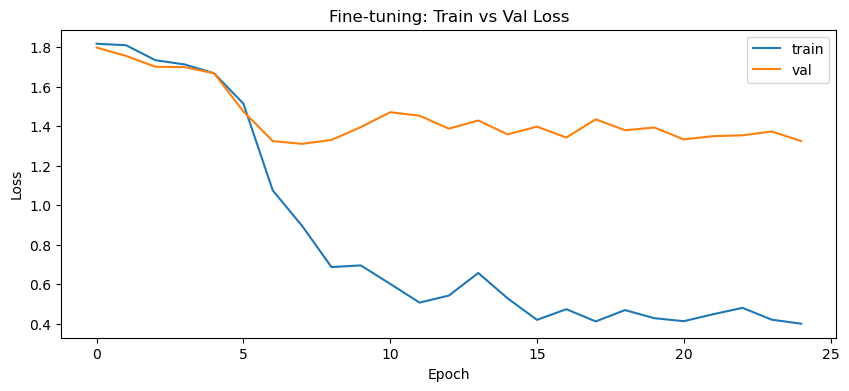

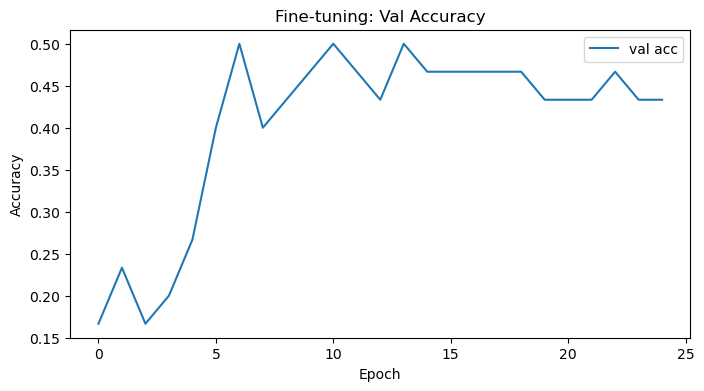

In [14]:
plt.figure(figsize=(10, 4))
plt.title('Fine-tuning: Train vs Val Loss')
plt.plot(train_losses_ft, label='train')
plt.plot(val_losses_ft, label='val')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(8, 4))
plt.title('Fine-tuning: Val Accuracy')
plt.plot(val_accs_ft, label='val acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


## Part 3: Save Model


**save model and label artifacts.**


In [15]:
torch.save(model_ft.cpu().state_dict(), model_dir / f"my_{model_name}_fine_tuned.pt")
model_ft = model_ft.to(device)

torch.save(class_names, model_dir / f"{model_name}_classes.pt")
torch.save(class_names, model_dir / f"{model_name}_classes.pt")

print('Saved:', model_dir / f"my_{model_name}_fine_tuned.pt")
print('Saved:', model_dir / f"{model_name}_classes.pt")


Saved: models/image_classifier/my_image_classifier_fine_tuned.pt
Saved: models/image_classifier/image_classifier_classes.pt


## Part 4: PIL Prediction Visualization


**perform single-image inference.**


In [16]:
# Choose one image for prediction (prefer images/, fallback to dataset/)
images_dir = pathlib.Path('images')
candidates = []
if images_dir.exists():
    candidates += [p for p in images_dir.rglob('*') if p.is_file() and p.suffix.lower() in {'.jpg','.jpeg','.png','.bmp','.webp'}]
if not candidates:
    candidates += [pathlib.Path(p[0]) for p in base_ds.samples]

if not candidates:
    raise FileNotFoundError('No image found for prediction.')

# Change this index to switch the image (0=first, 1=second, ...)
predict_image_index = 1
candidates = sorted(candidates)
img_path = candidates[predict_image_index % len(candidates)]

img = Image.open(img_path).convert('RGB')
print('Predict image:', img_path)
print('Image index:', predict_image_index, '/', len(candidates) - 1)


Predict image: dataset/Anger/img_050.jpg
Image index: 1 / 147


**import required libraries.**


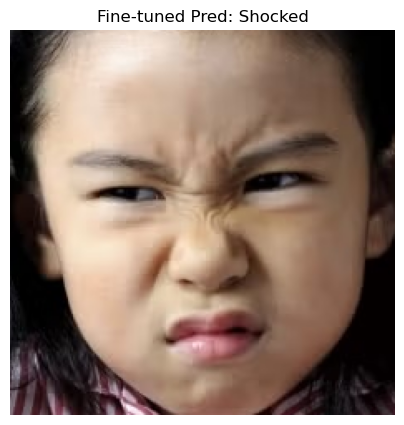

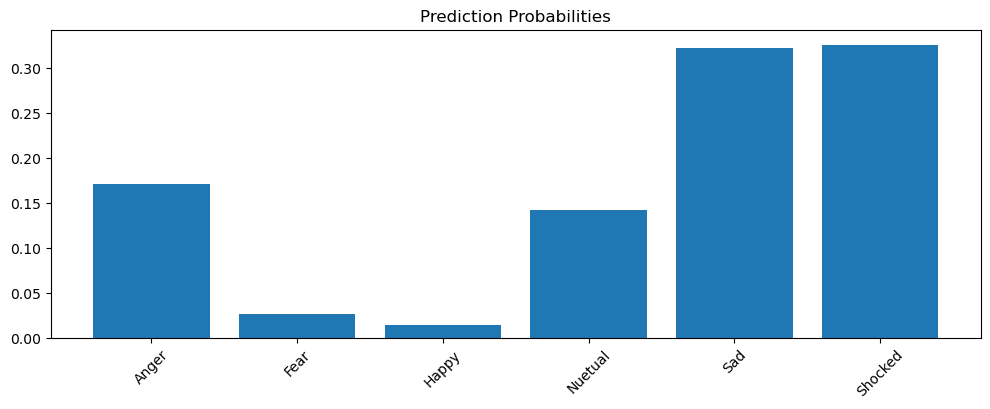

infer mode: haar_face
Prediction: Shocked (conf=0.3256)


In [17]:
pred_transform = v2.Compose([
    v2.Resize(256),
    v2.CenterCrop(224),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

def _center_crop_fallback(pil_img, ratio=0.75):
    w, h = pil_img.size
    side = int(min(w, h) * ratio)
    left = (w - side) // 2
    top = (h - side) // 2
    return pil_img.crop((left, top, left + side, top + side))

def _detect_and_crop_face_local(pil_img):
    try:
        import cv2
        arr = np.array(pil_img.convert("RGB"))
        gray = cv2.cvtColor(arr, cv2.COLOR_RGB2GRAY)
        cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")
        faces = cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(40, 40))
        if len(faces) > 0:
            x, y, w, h = max(faces, key=lambda f: f[2] * f[3])
            return pil_img.crop((int(x), int(y), int(x + w), int(y + h))), "haar_face"
    except Exception:
        pass
    return _center_crop_fallback(pil_img), "center_fallback"

# Improvement: prioritize face cropping to reduce background noise
use_face_crop = True
if use_face_crop:
    infer_img, crop_method = _detect_and_crop_face_local(img)
else:
    infer_img, crop_method = img, "raw"

input_img = pred_transform(infer_img).unsqueeze(0).to(device)

model_ft.eval()
with torch.no_grad():
    pred = torch.softmax(model_ft(input_img), dim=-1).cpu().numpy()[0]

idx = int(np.argmax(pred))

plt.figure(figsize=(5, 5))
plt.title(f"Fine-tuned Pred: {class_names[idx]}")
plt.imshow(infer_img)
plt.axis('off')
plt.show()

plt.figure(figsize=(12, 4))
plt.title('Prediction Probabilities')
plt.bar(class_names, pred)
plt.xticks(rotation=45)
plt.show()

print('infer mode:', crop_method)
print(f"Prediction: {class_names[idx]} (conf={pred[idx]:.4f})")


## Part 5: Black-and-white decontextualized prediction


**import required libraries.**


In [18]:
def center_crop_fallback(pil_img, ratio=0.75):
    w, h = pil_img.size
    side = int(min(w, h) * ratio)
    left = (w - side) // 2
    top = (h - side) // 2
    return pil_img.crop((left, top, left + side, top + side))


def detect_and_crop_face(pil_img):
    try:
        import cv2
        arr = np.array(pil_img.convert("RGB"))
        gray = cv2.cvtColor(arr, cv2.COLOR_RGB2GRAY)
        cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")
        faces = cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(40, 40))
        if len(faces) > 0:
            x, y, w, h = max(faces, key=lambda f: f[2] * f[3])
            return pil_img.crop((int(x), int(y), int(x + w), int(y + h))), 'haar_face'
    except Exception:
        pass
    return center_crop_fallback(pil_img), 'center_fallback'


**visualize prediction results.**


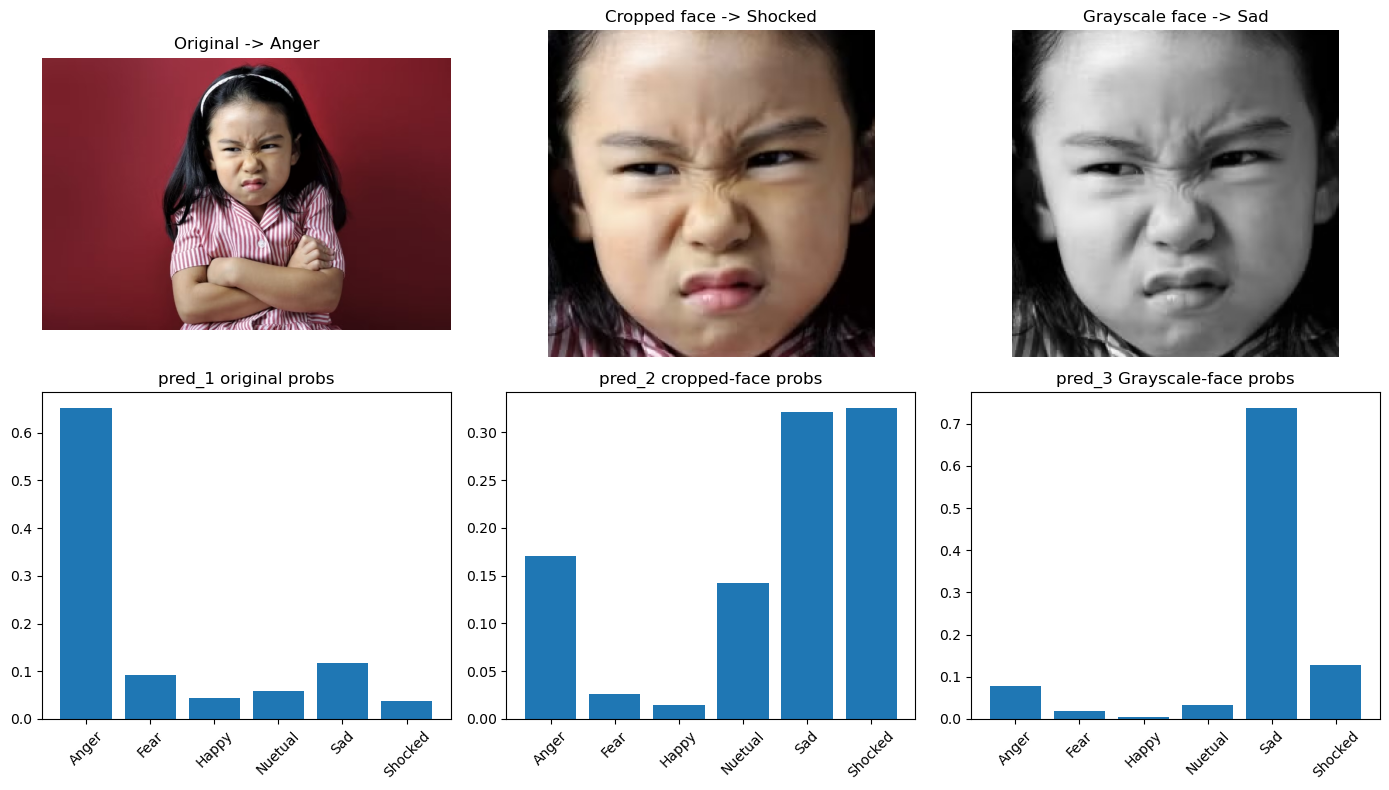

crop method: haar_face
pred_1 original: Anger (conf=0.6521)
pred_2 cropped face: Shocked (conf=0.3256)
pred_3 Grayscale face: Sad (conf=0.7378)


In [19]:
crop_img, crop_method = detect_and_crop_face(img)
gray_img = ImageOps.grayscale(crop_img).convert('RGB')

in_orig = pred_transform(img).unsqueeze(0).to(device)
in_crop = pred_transform(crop_img).unsqueeze(0).to(device)
in_gray = pred_transform(gray_img).unsqueeze(0).to(device)

model_ft.eval()
with torch.no_grad():
    p_orig = torch.softmax(model_ft(in_orig), dim=-1).cpu().numpy()[0]
    p_crop = torch.softmax(model_ft(in_crop), dim=-1).cpu().numpy()[0]
    p_gray = torch.softmax(model_ft(in_gray), dim=-1).cpu().numpy()[0]

i_orig = int(np.argmax(p_orig))
i_crop = int(np.argmax(p_crop))
i_gray = int(np.argmax(p_gray))

fig, axes = plt.subplots(2, 3, figsize=(14, 8))
axes[0, 0].imshow(img);      axes[0, 0].set_title(f"Original -> {class_names[i_orig]}"); axes[0, 0].axis('off')
axes[0, 1].imshow(crop_img); axes[0, 1].set_title(f"Cropped face -> {class_names[i_crop]}"); axes[0, 1].axis('off')
axes[0, 2].imshow(gray_img); axes[0, 2].set_title(f"Grayscale face -> {class_names[i_gray]}"); axes[0, 2].axis('off')

axes[1, 0].bar(class_names, p_orig); axes[1, 0].set_title('pred_1 original probs'); axes[1, 0].tick_params(axis='x', rotation=45)
axes[1, 1].bar(class_names, p_crop); axes[1, 1].set_title('pred_2 cropped-face probs'); axes[1, 1].tick_params(axis='x', rotation=45)
axes[1, 2].bar(class_names, p_gray); axes[1, 2].set_title('pred_3 Grayscale-face probs'); axes[1, 2].tick_params(axis='x', rotation=45)

plt.tight_layout(); plt.show()
print('crop method:', crop_method)
print(f"pred_1 original: {class_names[i_orig]} (conf={p_orig[i_orig]:.4f})")
print(f"pred_2 cropped face: {class_names[i_crop]} (conf={p_crop[i_crop]:.4f})")
print(f"pred_3 Grayscale face: {class_names[i_gray]} (conf={p_gray[i_gray]:.4f})")


This section compares original, cropped-face, and grayscale predictions to analyze decontextualization effects.


## Observation
When remove context, the model often changes its emotion guess and its confidence drops. With full images it is steadier, but with face-only crops or black-and-white versions it becomes less stable. This suggests the model uses context cues to make its decision.